In [1]:
import json
import pandas as pd
import community.community_louvain
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import gzip

In [2]:
df = pd.read_csv('dnsdata.csv')
columns = ['query', 'qclass', 'qtype', 'rcode', 'answers', 'TTLs']
df = df.loc[:, columns]
df

,query,qclass,qtype,rcode,answers,TTLs
0,4.5.6.7.in-addr.arpa,1.0,12.0,NaN,NaN,NaN
1,sinkhole.paloaltonetworks.com,1.0,28.0,NaN,NaN,NaN
2,time.windows.com,1.0,28.0,NaN,NaN,NaN
3,time.windows.com,1.0,1.0,NaN,NaN,NaN
4,time.milkyway.com,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...
564578,dns.msftncsi.com,1.0,28.0,0.0,['fd3e:4f5a:5b81::1'],[2259.0]
564579,api.stromcore.com,1.0,28.0,0.0,NaN,NaN
564580,api.stromcore.com,1.0,1.0,0.0,['142.93.157.148'],[3458.0]
564581,api.stromcore.com,1.0,28.0,0.0,NaN,NaN


In [3]:
df = df[df['answers'].notna()]
df['answers'] = df['answers'].str.len()
df

,query,qclass,qtype,rcode,answers,TTLs
16,www.google.com,1.0,1.0,0.0,18,[89.0]
27,ca5-word-collab.officeapps.live.com,1.0,1.0,0.0,123,"[220.0, 60.0, 1047.0]"
28,solar-speckled-power.glitch.me,1.0,1.0,0.0,32,"[60.0, 60.0]"
29,ocsp.godaddy.com.akadns.net,1.0,1.0,0.0,90,"[1.0, 1.0, 1.0, 1.0, 1.0]"
31,dcwifi.akamai.net,1.0,1.0,0.0,77,"[12.0, 12.0, 12.0]"
...,...,...,...,...,...,...
564573,d3tracking.rbc.com,1.0,65.0,0.0,38,[60.0]
564575,dns.msftncsi.com,1.0,28.0,0.0,21,[555.0]
564576,dns.msftncsi.com,1.0,28.0,0.0,21,[2909.0]
564578,dns.msftncsi.com,1.0,28.0,0.0,21,[2259.0]


In [4]:
df['TTLs'] = df['TTLs'].apply(lambda x: [] if pd.isna(x) else eval(x))
df['TTLs'] = df['TTLs'].apply(lambda x: sum(x))

In [5]:
df['TTLs'] = df['TTLs'].replace(0.0, -1.0)
df

,query,qclass,qtype,rcode,answers,TTLs
16,www.google.com,1.0,1.0,0.0,18,89.0
27,ca5-word-collab.officeapps.live.com,1.0,1.0,0.0,123,1327.0
28,solar-speckled-power.glitch.me,1.0,1.0,0.0,32,120.0
29,ocsp.godaddy.com.akadns.net,1.0,1.0,0.0,90,5.0
31,dcwifi.akamai.net,1.0,1.0,0.0,77,36.0
...,...,...,...,...,...,...
564573,d3tracking.rbc.com,1.0,65.0,0.0,38,60.0
564575,dns.msftncsi.com,1.0,28.0,0.0,21,555.0
564576,dns.msftncsi.com,1.0,28.0,0.0,21,2909.0
564578,dns.msftncsi.com,1.0,28.0,0.0,21,2259.0


In [6]:
df['qlength'] = df['query'].str.len()

In [7]:
df['query'].unique()

array(['www.google.com', 'ca5-word-collab.officeapps.live.com',
       'solar-speckled-power.glitch.me', ..., 'api.taplytics.com',
       '202.153.26.184.in-addr.arpa', 'ping.taplytics.com'], dtype=object)

In [8]:
df = df.dropna(subset=['query'])
df.fillna(-1.0, inplace=True)
df = df[~df['query'].str.endswith('.arpa')]
df

,query,qclass,qtype,rcode,answers,TTLs,qlength
16,www.google.com,1.0,1.0,0.0,18,89.0,14
27,ca5-word-collab.officeapps.live.com,1.0,1.0,0.0,123,1327.0,35
28,solar-speckled-power.glitch.me,1.0,1.0,0.0,32,120.0,30
29,ocsp.godaddy.com.akadns.net,1.0,1.0,0.0,90,5.0,27
31,dcwifi.akamai.net,1.0,1.0,0.0,77,36.0,17
...,...,...,...,...,...,...,...
564573,d3tracking.rbc.com,1.0,65.0,0.0,38,60.0,18
564575,dns.msftncsi.com,1.0,28.0,0.0,21,555.0,16
564576,dns.msftncsi.com,1.0,28.0,0.0,21,2909.0,16
564578,dns.msftncsi.com,1.0,28.0,0.0,21,2259.0,16


In [9]:
df['query'].unique()

array(['www.google.com', 'ca5-word-collab.officeapps.live.com',
       'solar-speckled-power.glitch.me', ..., 'mobile.rbcroyalbank.com',
       'api.taplytics.com', 'ping.taplytics.com'], dtype=object)

In [10]:
df['query'] = df['query'].astype(str)
df['query_parts_count'] = df['query'].apply(lambda x: len(x.split('.')))
df

,query,qclass,qtype,rcode,answers,TTLs,qlength,query_parts_count
16,www.google.com,1.0,1.0,0.0,18,89.0,14,3
27,ca5-word-collab.officeapps.live.com,1.0,1.0,0.0,123,1327.0,35,4
28,solar-speckled-power.glitch.me,1.0,1.0,0.0,32,120.0,30,3
29,ocsp.godaddy.com.akadns.net,1.0,1.0,0.0,90,5.0,27,5
31,dcwifi.akamai.net,1.0,1.0,0.0,77,36.0,17,3
...,...,...,...,...,...,...,...,...
564573,d3tracking.rbc.com,1.0,65.0,0.0,38,60.0,18,3
564575,dns.msftncsi.com,1.0,28.0,0.0,21,555.0,16,3
564576,dns.msftncsi.com,1.0,28.0,0.0,21,2909.0,16,3
564578,dns.msftncsi.com,1.0,28.0,0.0,21,2259.0,16,3


In [11]:
def query_length(query):
    return len(query)

def query_tld_length(query):
    return len(query.split('.')[-1])

def query_domain_length(query):
    try:
        length =  len(query.split('.')[-2])
    except:
        length = 0
    return length

qlengths = [query_length(query) for query in df['query']]
qsufflengths = [query_tld_length(query) for query in df['query']]
qdomlengths = [query_domain_length(query) for query in df['query']]

df['qlength'] = qlengths
df['tldlength'] = qsufflengths
df['domainlength'] = qdomlengths
df

,query,qclass,qtype,rcode,answers,TTLs,qlength,query_parts_count,tldlength,domainlength
16,www.google.com,1.0,1.0,0.0,18,89.0,14,3,3,6
27,ca5-word-collab.officeapps.live.com,1.0,1.0,0.0,123,1327.0,35,4,3,4
28,solar-speckled-power.glitch.me,1.0,1.0,0.0,32,120.0,30,3,2,6
29,ocsp.godaddy.com.akadns.net,1.0,1.0,0.0,90,5.0,27,5,3,6
31,dcwifi.akamai.net,1.0,1.0,0.0,77,36.0,17,3,3,6
...,...,...,...,...,...,...,...,...,...,...
564573,d3tracking.rbc.com,1.0,65.0,0.0,38,60.0,18,3,3,3
564575,dns.msftncsi.com,1.0,28.0,0.0,21,555.0,16,3,3,8
564576,dns.msftncsi.com,1.0,28.0,0.0,21,2909.0,16,3,3,8
564578,dns.msftncsi.com,1.0,28.0,0.0,21,2259.0,16,3,3,8


In [12]:
data = df[['qclass', 'qtype',  'rcode', 'answers', 'TTLs', 'qlength', 'query_parts_count', 'tldlength', 'domainlength']].to_numpy()
data

array([[ 1.,  1.,  0., ...,  3.,  3.,  6.],
       [ 1.,  1.,  0., ...,  4.,  3.,  4.],
       [ 1.,  1.,  0., ...,  3.,  2.,  6.],
       ...,
       [ 1., 28.,  0., ...,  3.,  3.,  8.],
       [ 1., 28.,  0., ...,  3.,  3.,  8.],
       [ 1.,  1.,  0., ...,  3.,  3.,  9.]])

In [13]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data)
scaled = scaler.transform(data)

pca = PCA(3)
pca.fit(scaled)
reduced = pca.transform(scaled)

dbscan = DBSCAN(n_jobs=-1, min_samples=50, eps=0.8)
dbscan.fit(scaled)

y_labels = dbscan.labels_
y_labels

array([0, 1, 2, ..., 0, 0, 0])

In [14]:
import numpy as np
np.unique(y_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69])

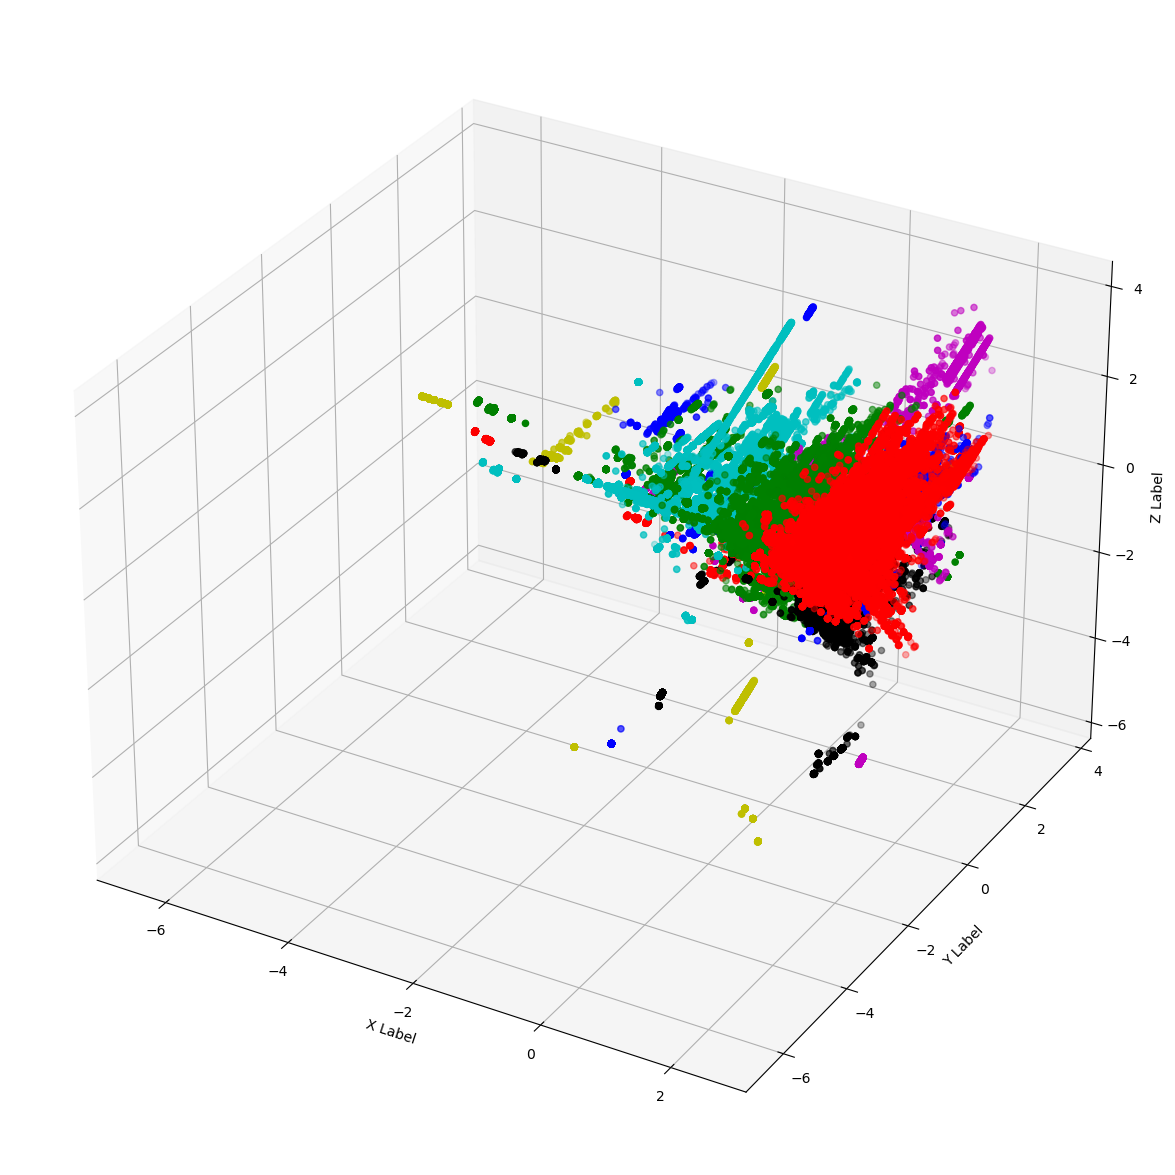

In [15]:
import matplotlib.pyplot as plt

def scatter3d(data, labels):
    clusters = len(np.unique(labels))
    colors=list("rgbcmyk")
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111, projection='3d')
    for cluster in range(clusters):
        ax.scatter(data[labels==cluster, 0], data[labels==cluster, 1], data[labels==cluster, 2], c=colors[cluster%len(colors)])
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

scatter3d(reduced, y_labels)

In [16]:
data

array([[ 1.,  1.,  0., ...,  3.,  3.,  6.],
       [ 1.,  1.,  0., ...,  4.,  3.,  4.],
       [ 1.,  1.,  0., ...,  3.,  2.,  6.],
       ...,
       [ 1., 28.,  0., ...,  3.,  3.,  8.],
       [ 1., 28.,  0., ...,  3.,  3.,  8.],
       [ 1.,  1.,  0., ...,  3.,  3.,  9.]])

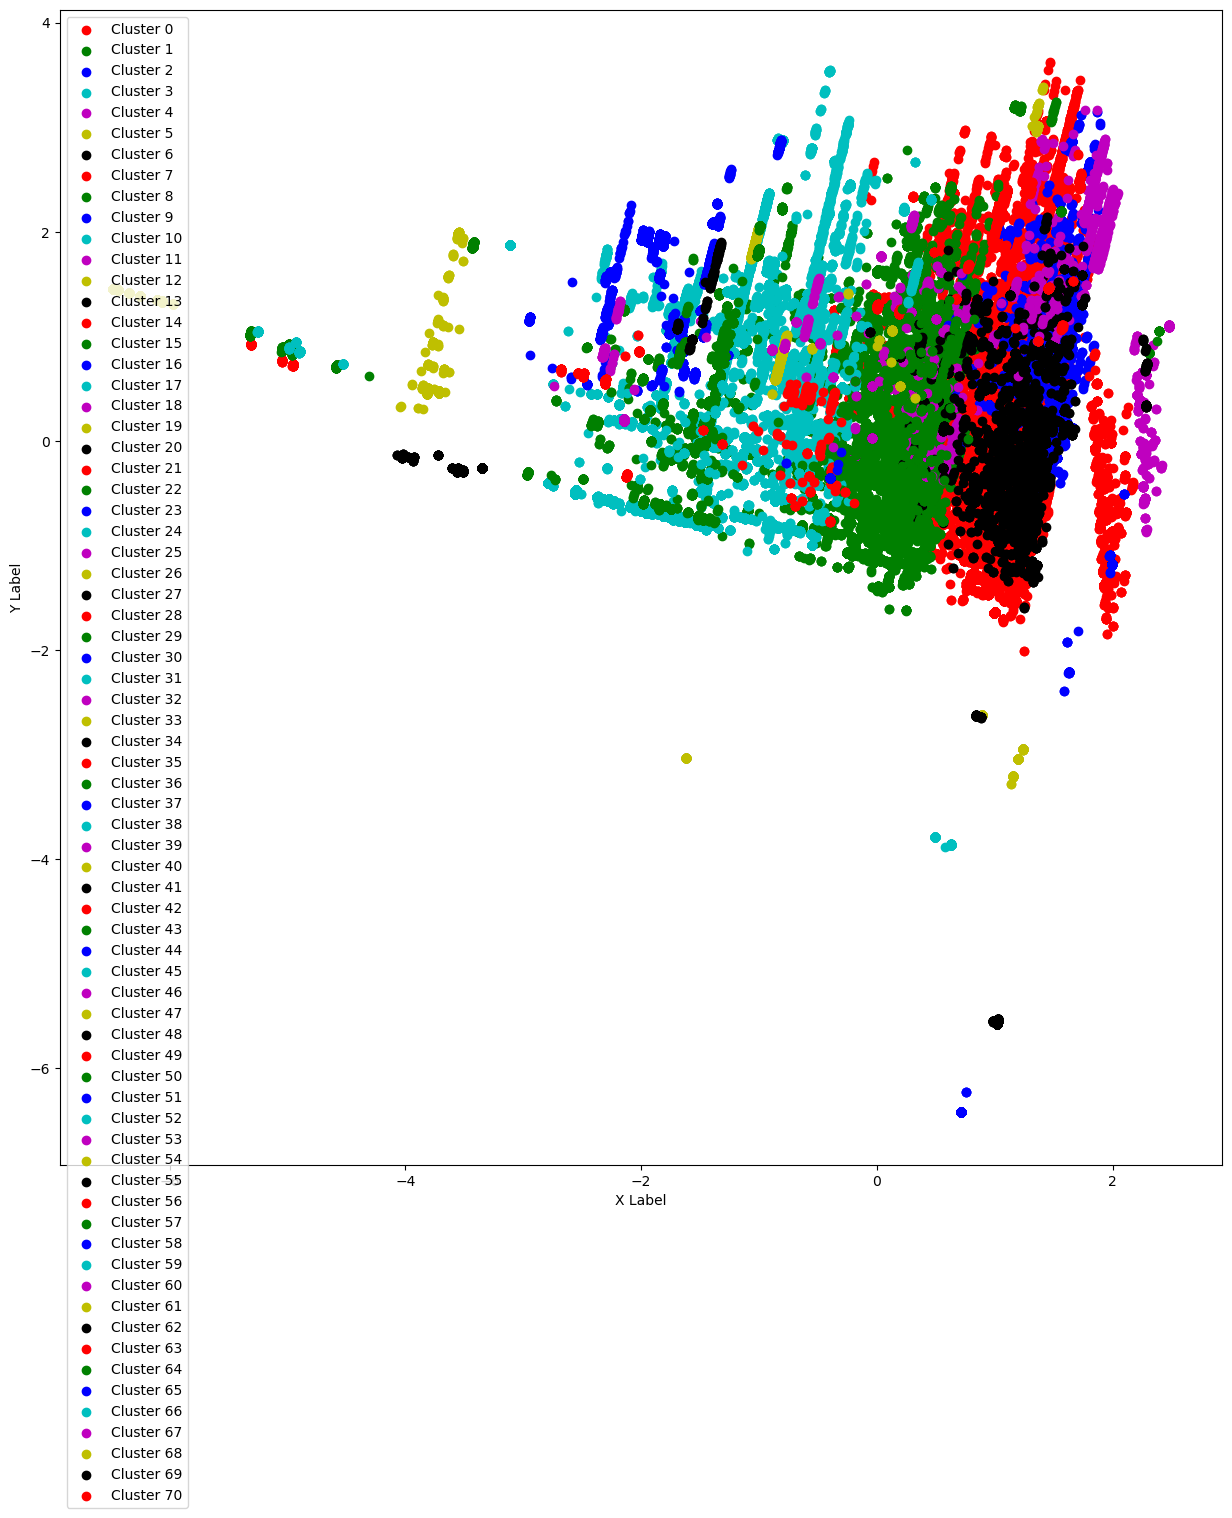

In [17]:
import matplotlib.pyplot as plt

def scatter2d(data, labels):
    clusters = len(np.unique(labels))
    colors = list("rgbcmyk")
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax = fig.add_subplot(111)
    for cluster in range(clusters):
        ax.scatter(data[labels == cluster, 0], data[labels == cluster, 1], c=colors[cluster % len(colors)], label=f'Cluster {cluster}')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.legend()
    plt.show()

scatter2d(reduced, y_labels)

In [20]:
import pandas as pd

df['cluster'] = y_labels
cluster = -1

df.loc[df['cluster'] == cluster]

,query,qclass,qtype,rcode,answers,TTLs,qlength,query_parts_count,tldlength,domainlength,cluster
428,vapp-updates.vmware.com,1.0,28.0,0.0,202,20128.0,23,3,3,6,-1
1360,nrdp.nccp.netflix.com,1.0,28.0,0.0,308,610.0,21,4,3,7,-1
1368,nrdp.prod.cloud.netflix.com,1.0,28.0,0.0,249,354.0,27,5,3,7,-1
1384,cac-collabrtc.rtc.trafficmanager.net.b-0016.b-...,1.0,1.0,0.0,39,349.0,56,7,3,8,-1
1507,login.kanda.dk,1.0,28.0,0.0,103,682.0,14,3,2,5,-1
...,...,...,...,...,...,...,...,...,...,...,...
563755,koritastiresinc.com,1.0,1.0,0.0,16,86400.0,19,2,3,15,-1
563777,koritastiresinc.com,1.0,1.0,0.0,16,86400.0,19,2,3,15,-1
563835,www.merchant-center-analytics.goog,1.0,65.0,0.0,21,2104.0,34,3,4,25,-1
563858,cac-word-view.wac.trafficmanager.net.wac-0003....,1.0,65.0,0.0,27,10.0,87,10,3,10,-1
